<a href="https://colab.research.google.com/github/cjqian/flappy/blob/master/card_game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background

Let's wager on a card game. In front of you is a shuffled deck of 52 cards face-down. Half are red, half are black. Once you saw "halt", I'll flip over the next card and end the game. If the final card is red, you win 1. Otherwise, you lose 1. Let's play!

In [1]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

# Set up the game/environment.

In [2]:
# The actions are to stop or to continue.
ACTION_GO = 0
ACTION_STOP = 1

# The observation is the entire history of the game thus far. [RED, BLACK...]
CARD_RED = 0
CARD_BLACK = 1

DECK_SIZE = 52

class Environment():
  def __init__(self):
    self._dealt_cards = []
    
    # Same number of red and black cards.
    red_cards = [CARD_RED] * int(DECK_SIZE / 2)
    black_cards = [CARD_BLACK] * int(DECK_SIZE / 2)
    self._deck = red_cards + black_cards
    random.shuffle(self._deck)

  def step(self, action):
    """Returns reward, state, and whether the game is done."""
    done = False
    if len(self._deck) == 1 or action == ACTION_STOP:
      done = True
    card = self._deck.pop()
    self._dealt_cards.append(card)
    reward = 0

  # The rewards are $1 if we win, -$1 if we lost,
  # or $0 if the game has not ended.
    if done:
      reward = 1 if card == CARD_RED else -1
    return (self.get_n_red_black_state(), reward, done)

  def get_full_state(self):
    return self._dealt_cards

  def get_n_red_black_state(self):
    n_red = len([x for x in self._dealt_cards if x == CARD_RED])
    n_black = len(self._dealt_cards) - n_red
    return [n_red, n_black]

# Approach 0: Random Baseline

Score over time: -0.018


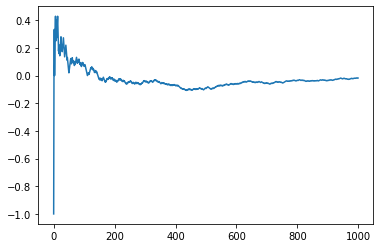

In [4]:
RANDOM_REWARDS = []

total_episodes = 1000
for episode in range(1, total_episodes+ 1):
    if (episode % 10000) == 0:
        print("Progress: {} ({})".format(round((episode + 0.0)/total_episodes, 4),
                                         round(sum(rewards) / len(rewards), 4)))
    # Reset the environment
    env = Environment()
    state, reward, done = env.step(ACTION_GO)
    step = 0
    total_rewards = 0
    
    while not done:
        action = random.randint(0, 1)

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done = env.step(action)
        total_rewards += reward
        
    # Reduce epsilon (because we need less and less exploration)
    RANDOM_REWARDS.append(total_rewards)
    
print ("Score over time: " +  str(sum(RANDOM_REWARDS)/total_episodes))

# Plot learning.
pd.Series(RANDOM_REWARDS).expanding().mean().plot()

# Approach 1: Q Learning

In [175]:
# Initialize hyperparameters.

total_episodes = 100000     # Total episodes
learning_rate = 0.7          # Learning rate
gamma = 0.95                 # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.005            # Exponential decay rate for exploration prob

Progress: 0.1 (0.0009)
Progress: 0.2 (0.0027)
Progress: 0.3 (-0.0019)
Progress: 0.4 (-0.0028)
Progress: 0.5 (-0.0023)
Progress: 0.6 (-0.0037)
Progress: 0.7 (-0.004)
Progress: 0.8 (-0.0039)
Progress: 0.9 (-0.0028)
Progress: 1.0 (-0.0024)
Score over time: -0.0024
CPU times: user 1min 13s, sys: 367 ms, total: 1min 13s
Wall time: 1min 13s


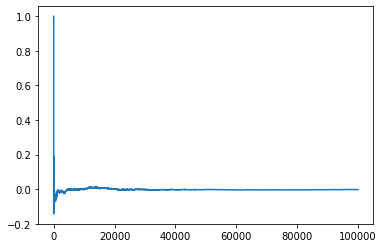

In [179]:
%%time

def get_hash_key(state):
  return tuple(state)

# List of rewards
rewards = []
q_map  = {}

# 2 For life or until learning is stopped
for episode in range(1, total_episodes+ 1):
    if (episode % 10000) == 0:
        print("Progress: {} ({})".format(round((episode + 0.0)/total_episodes, 4),
                                         round(sum(rewards) / len(rewards), 4)))
    # Reset the environment
    env = Environment()
    state, reward, done = env.step(ACTION_GO)
    step = 0
    total_rewards = 0
    while not done:
        exp_tradeoff = random.uniform(0, 1)
        explore = exp_tradeoff <= epsilon

        state_h = get_hash_key(state)
        if state_h not in q_map:
          q_map[state_h] = [0.0, 0.0]

        if explore:
          # Choose a random action.
          action = random.randint(0, 1)
        else:
          action = np.argmax(q_map[state_h])

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done = env.step(action)
        new_state_h = get_hash_key(new_state)

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        if new_state_h not in q_map:
          q_map[new_state_h] = [0.0, 0.0]

        q_map[state_h][action] = q_map[state_h][action] + learning_rate * (
            reward + gamma * np.max(q_map[new_state_h]) - q_map[state_h][action])
        
        total_rewards += reward
        
        # Our new state is state
        state = new_state
        
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
    rewards.append(total_rewards)
    
print ("Score over time: " +  str(sum(rewards)/total_episodes))

# Plot learning.
Q_LEARNING_REWARDS = rewards
pd.Series(Q_LEARNING_REWARDS).expanding().mean().plot()

# Approach 2: SARSA(0)

In [30]:
# Initialize hyperparameters.

total_episodes = 1000000     # Total episodes
gamma = 0.85                 # Discounting rate
alpha = .8

Progress: 0.1 (-0.002)
Progress: 0.2 (0.0003)
Progress: 0.3 (0.0017)
Progress: 0.4 (0.0026)
Progress: 0.5 (0.0014)
Progress: 0.6 (0.0024)
Progress: 0.7 (0.0019)
Progress: 0.8 (0.0014)
Progress: 0.9 (0.0012)
Progress: 1.0 (0.0004)
Score over time: 0.000356
CPU times: user 41.4 s, sys: 43.1 ms, total: 41.5 s
Wall time: 41.5 s


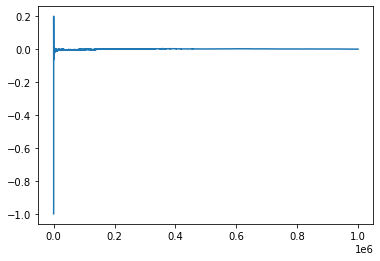

In [31]:
%%time

# Initialize Q(s, a) arbitrarily.
Q = {}
for i in range(0, 27):
  for j in range(0, 27):
    #Q[(i, j)] = [random.uniform(), random.uniform()]
    Q[(i, j)] = [0., 0.]

# Update the terminal states.
Q[(0, 26)] = 0
Q[(26, 0)] = 0

def choose_action(state, map=Q):
  exp_tradeoff = random.uniform(0, 1)
  explore = exp_tradeoff <= epsilon
  if explore:
    action = random.randint(0, 1)
  else:
    action = np.argmax(Q[tuple(state)])

  return action

rewards = []
for episode in range(1, total_episodes+ 1):
#for episode in range(1, 2):
    if (episode % 100000) == 0:
        print("Progress: {} ({})".format(round((episode + 0.0)/total_episodes, 4),
                                         round(sum(rewards) / len(rewards), 4)))
    
    env = Environment()
    done = False

    # Initialize S.
    state = [0, 0]
    step = 0
    total_rewards = 0

    # Choose A from S using policy derived from Q.
    action = choose_action(state)
    #print("Initial action: {}".format(action))
    while not done:
      # Take action A, observe R, S'.
      state_p, reward, done = env.step(action)
      #print("New state: {}".format(state_p))
      # Choose A' from S'.
      action_p = choose_action(state_p)
      #print("New action: {}".format(action_p))

      # Update Q.
      init_q = Q[tuple(state)][action]
      td_error = reward + gamma * Q[tuple(state_p)][action_p] - init_q
      Q[tuple(state)][action] = init_q + alpha * td_error
      #print(Q[tuple(state)][action])

      # S <- S', A <- A'
      state = state_p
      action = action_p
      
      total_rewards += reward

    rewards.append(total_rewards)
    
print ("Score over time: " +  str(sum(rewards)/total_episodes))

# Plot learning.
SARSA_REWARDS = rewards
pd.Series(SARSA_REWARDS).expanding().mean().plot()

# Approach 3: SARSA($\lambda$)

In [51]:
# Initialize hyperparameters.

total_episodes = 1000000     # Total episodes
gamma = 0.8           # Discounting factor.
lambd = .8
alpha = .8             # Learning rate.

Progress: 0.01 (-0.0029)
Progress: 0.02 (0.0099)
Progress: 0.03 (0.0082)
Progress: 0.04 (0.005)
Progress: 0.05 (0.0068)
Progress: 0.06 (0.0064)
Progress: 0.07 (0.0056)
Progress: 0.08 (0.0045)
Progress: 0.09 (0.0011)
Progress: 0.1 (0.0013)
Progress: 0.11 (-0.0003)
Progress: 0.12 (-0.001)
Progress: 0.13 (-0.0009)
Progress: 0.14 (-0.0005)
Progress: 0.15 (-0.0022)
Progress: 0.16 (-0.0021)
Progress: 0.17 (-0.0016)
Progress: 0.18 (-0.0009)
Progress: 0.19 (-0.0017)
Progress: 0.2 (-0.0013)
Progress: 0.21 (-0.0006)
Progress: 0.22 (-0.0001)
Progress: 0.23 (-0.0002)
Progress: 0.24 (0.0004)
Progress: 0.25 (0.0005)
Progress: 0.26 (-0.0002)
Progress: 0.27 (-0.0003)
Progress: 0.28 (-0.0006)
Progress: 0.29 (-0.0002)
Progress: 0.3 (-0.0008)
Progress: 0.31 (-0.0002)
Progress: 0.32 (0.0005)
Progress: 0.33 (0.0002)
Progress: 0.34 (0.0006)
Progress: 0.35 (0.0006)
Progress: 0.36 (0.0004)
Progress: 0.37 (0.0005)
Progress: 0.38 (0.0005)
Progress: 0.39 (0.0005)
Progress: 0.4 (0.0007)
Progress: 0.41 (0.0005)
Pr

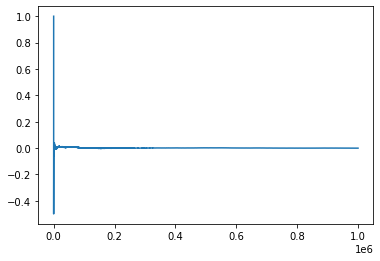

In [52]:
%%time

def get_states_iter():
  for i in range(0, 27):
    for j in range(0, 27):
      yield (i, j)

# Initialize Q(s, a) arbitrarily.
Q = {}
E = {}

states_iter = get_states_iter()
for s in states_iter:
  Q[s] = [0., 0.]

def choose_action(state, map=Q):
  exp_tradeoff = random.uniform(0, 1)
  explore = exp_tradeoff <= epsilon
  if explore:
    action = random.randint(0, 1)
  else:
    action = np.argmax(Q[tuple(state)])

  return action

rewards = []
for episode in range(1, total_episodes+ 1):
  if (episode % 10000) == 0:
      print("Progress: {} ({})".format(round((episode + 0.0)/total_episodes, 4),
                                        round(sum(rewards) / len(rewards), 4)))
  
  env = Environment()
  done = False
     
  states_iter = get_states_iter()
  for s in states_iter:
    E[s] = [0., 0.]

  # Initialize S and A.
  state = [0, 0]
  action = choose_action(state)
  step = 0
  total_rewards = 0

  #print("Initial action: {}".format(action))
  while not done:
    # Take action A, observe R, S'.
    state_p, reward, done = env.step(action)
    
    # Choose A' from S'.
    action_p = choose_action(state_p)

    # Calculate the TD error.
    init_q = Q[tuple(state)][action]
    td_error = reward + gamma * Q[tuple(state_p)][action_p] - init_q

    # Increment E.
    E[tuple(state)][action] += 1

    # For all states and actions:
    states_iter = get_states_iter()
    for s in states_iter:
      for a in [0, 1]:
        Q[s][a] = Q[s][a] + alpha * td_error * E[s][a]
        E[s][a] = gamma * lambd * E[s][a]
    
    # S <- S', A <- A'
    state = state_p
    action = action_p
    
    total_rewards += reward

  rewards.append(total_rewards)
  
print ("Score over time: " +  str(sum(rewards)/total_episodes))

# Plot learning.
LSARSA_REWARDS = rewards
pd.Series(LSARSA_REWARDS).expanding().mean().plot()

# Test it out!

In [57]:
N_TRIALS = 10000
trial_rewards = []

def get_random_action(state):
  return random.randint(0, 1)

def get_q_action(state):
  return np.argmax(q_map[tuple(state)])

def get_sarsal_action(state):
  return np.argmax(Q[tuple(state)])

for episode in range(N_TRIALS):
    env = Environment()
    state, _, done = env.step(ACTION_GO)

    while (not done):
        # Take the action (index) that have the maximum expected future reward given that state
        # action = get_random_action(state)
        # action = get_q_action(state)
        action = get_sarsal_action(state)

        new_state, reward, done = env.step(action)
        
        if done:
            # We print the number of step it took.
    #        print("\tEpisode {}: {}".format(episode, reward))
            trial_rewards.append(reward)
            break

        state = new_state

print("Payoff: {}".format(sum(trial_rewards)))

Payoff: 38


# Conclusions

Turns out, there is no way to beat random performance.